In [41]:
# El mismo que el anterior pero solo con 2 clases: positivo y negativo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_ = pd.read_csv('../AirlineTweets.csv')

In [3]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df = df_[['airline_sentiment', 'text']].copy()

In [5]:
#df = df[df.airline_sentiment != "neutral"]

In [6]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot: >

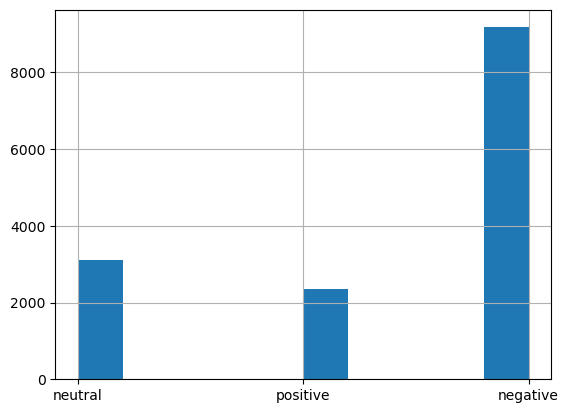

In [7]:
df['airline_sentiment'].hist()

In [8]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [9]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('../data.csv', index=None)

In [10]:
#!head data.csv
!findstr /n "." ../data.csv | findstr "^.:"

1:sentence,label
2:@VirginAmerica What @dhepburn said.,2
3:@VirginAmerica plus you've added commercials to the experience... tacky.,1
4:@VirginAmerica I didn't today... Must mean I need to take another trip!,2
5:"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
6:@VirginAmerica and it's a really big bad thing about it,0
7:"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
8:it's really the only bad thing about flying VA",0
9:"@VirginAmerica yes, nearly every time I fly VX this â€œear wormâ€� wonâ€™t go away :)",1


In [11]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='../data.csv')

Extracting data files: 100%|██████████| 1/1 [00:00<?, ?it/s]


Dataset csv downloaded and prepared to C:/Users/sthor/.cache/huggingface/datasets/csv/default-218b44571d69e1b3/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 982.73it/s]


In [12]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [13]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [14]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [15]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

In [16]:
# if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train1.csv', 'train2.csv'],
#                 'test': 'test.csv'
#     }
# )

In [17]:
checkpoint = 'distilbert-base-cased'

In [18]:
from transformers import AutoTokenizer

In [19]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [20]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [21]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

In [22]:
from transformers import AutoModelForSequenceClassification, AutoConfig, \
  Trainer, TrainingArguments

In [23]:
config = AutoConfig.from_pretrained(checkpoint)

In [24]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.27.3",
  "vocab_size": 28996
}

In [25]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [26]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [27]:
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [28]:
config.id2label

{1: 'positive', 0: 'negative', 2: 'neutral'}

In [29]:
config.label2id

{'positive': 1, 'negative': 0, 'neutral': 2}

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config=config)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [31]:
from torchinfo import summary

In [32]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [33]:
training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [34]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [35]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [36]:
trainer.train()

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.544800,0.433206,0.827641,0.770510
2,0.344200,0.486911,0.835838,0.786578
3,0.237500,0.658450,0.837887,0.784891


TrainOutput(global_step=1923, training_loss=0.3244379691264311, metrics={'train_runtime': 114.8564, 'train_samples_per_second': 267.673, 'train_steps_per_second': 16.743, 'total_flos': 388376501242176.0, 'train_loss': 0.3244379691264311, 'epoch': 3.0})

In [37]:
!dir training_dir

 El volumen de la unidad C es Windows
 El número de serie del volumen es: 14FB-F245

 Directorio de C:\Users\sthor\Programas_codigo_fuente\Udemy\Data Science - Transformers for Natural Language Processing\Fine-Tuning (Intermediate)\training_dir

01/06/2023  20:40    <DIR>          .
02/06/2023  09:19    <DIR>          ..
01/06/2023  20:40    <DIR>          checkpoint-1010
01/06/2023  18:36    <DIR>          checkpoint-1282
01/06/2023  20:40    <DIR>          checkpoint-1515
01/06/2023  18:37    <DIR>          checkpoint-1923
01/06/2023  20:39    <DIR>          checkpoint-505
01/06/2023  18:36    <DIR>          checkpoint-641
02/06/2023  09:18    <DIR>          runs
               0 archivos              0 bytes
               9 dirs  1,421,994,029,056 bytes libres


In [39]:
from transformers import pipeline

In [40]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1282',
                      device=0)

In [41]:
s = split['test']['sentence'][0]
print(s)
savedmodel(s)

@JetBlue thank you!


[{'label': 'positive', 'score': 0.9459161758422852}]